
# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
import time
from datetime import timedelta
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from PIL import Image
from random import randint
import math
import tensorflow as tf
import collections
from sklearn.utils import shuffle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'
labels = []
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open('signnames.csv', mode='r') as f:
    next(f) # skip the first line
    reader = csv.reader(f)
    for row in reader:
        labels.append(row[1])
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("Training Set Total: {} samples".format(len(X_train)))
print("Test Set Total: {} samples".format(len(X_test)))

Training Set Total: 39209 samples
Test Set Total: 12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

img_size = 32
img_size_flat = img_size*img_size  # Images will be converted to grayscale
number_channels = 1

# TODO: What's the shape of an traffic sign image?
image_shape = (img_size, img_size, 3)

# TODO: How many unique classes/labels there are in the dataset.
number_classes = 43

print("Image shape =", image_shape)
print("Number of classes =", number_classes)

Image shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

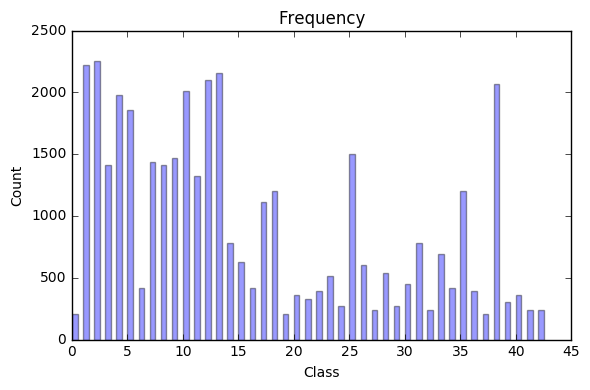

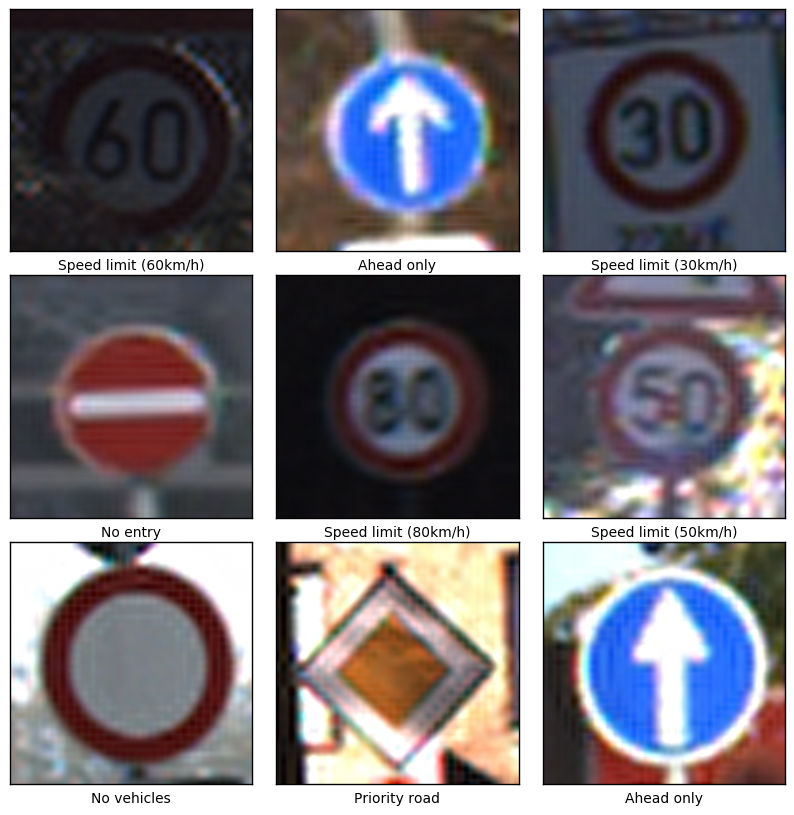

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def plot_labels_count(y_train):
    counter=collections.Counter(y_train)
    
    labels_frequency = [x[1] for x in sorted(counter.most_common())]
    n_groups = len(labels_frequency)
    
    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.5
    opacity = 0.4

    rects1 = plt.bar(index, labels_frequency, bar_width,
                     alpha=opacity,
                     color='b')

    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Frequency')

    plt.tight_layout()
    plt.show()

def plot_images(train_data, train_labels, labels, plots_number=9):
    # Plots random images from the dataset
    # Create figure with sub-plots.
    
    y_axes = 3
    x_axes = math.ceil(plots_number/3.0)
    
    fig, axes = plt.subplots(x_axes, y_axes, figsize=(10, 10))
    
    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    y = 0
    x = 0
    for i in range(0, plots_number):
        
        ax = axes[x][y]
        rnd_index = randint(0,len(train_data))
        ax.imshow(train_data[rnd_index] / 255.0, interpolation='sinc', cmap='gray')
        try:
            ax.set_xlabel(labels[train_labels[rnd_index]])
        except:
            print('Sign Without Label')
        y+=1
        if y == 3:
            y=0
            x+= 1

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

plot_labels_count(y_train)

plot_images(X_train, y_train, labels)

%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Turn image to greyscale function
def RGB_2_GRAY(image_array):
    return cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

### Normalization function
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )


###train data to grayscale and normalize
grayscale_train = np.zeros([n_train,32,32]) 
normalized_train = np.zeros([n_train,32,32])
for i in range(n_train):
    grayscale_train[i] = RGB_2_GRAY(X_train[i])
    normalized_train[i] = normalize_grayscale(grayscale_train[i])

###Turn test data grayscale and normalize it
grayscale_test = np.zeros([n_test,32,32]) 
normalized_test = np.zeros([n_test,32,32])
for i in range(n_test):
    grayscale_test[i] = RGB_2_GRAY(X_test[i])
    normalized_test[i] = normalize_grayscale(grayscale_test[i])

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** Converting to Grayscale to improve accuracy. See the whole processing is reduced instead of processing RGB its only one now. Its better in ML Algo too. Based on the videos and forum suggestions i have used normalization function. I have made it in such a way that it has Zero Mean and Zero Standard Deviation. Which makes it again better. I have changed the greyscale value from 0-255 to 0.1 to 0.9. 
I would say preprocessing makes it easy for the data to be processed and learned.

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, 32, 32, num_channels)).astype(np.float32)
    labels = (np.arange(number_classes) == labels[:,None]).astype(np.float32)
    return dataset, labels

    
###SHUFFLING
shuffled_train_dataset, shuffled_train_labels = shuffle(normalized_train,y_train)

###TRAINING
train_dataset = shuffled_train_dataset[0:30000]
train_labels = shuffled_train_labels[0:30000]
train_dataset , train_labels = reformat(train_dataset , train_labels)

###VALIDATION
valid_dataset = shuffled_train_dataset[30000:39209]
valid_labels = shuffled_train_labels[30000:39209]
valid_dataset , valid_labels = reformat(valid_dataset , valid_labels)

###TESTING: already X_test, not modified
test_dataset = normalized_test[:]
test_labels = y_test[:]
test_dataset , test_labels = reformat(test_dataset , test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

### Feel free to use as many code cells as needed.

Training set (30000, 32, 32, 1) (30000, 43)
Validation set (9209, 32, 32, 1) (9209, 43)
Test set (12630, 32, 32, 1) (12630, 43)


In [6]:
print(normalized_train[0][1])

[ 0.36039216  0.35098039  0.36980392  0.42941176  0.5172549   0.50156863
  0.44196078  0.50784314  0.70235294  0.88431373  0.88745098  0.88745098
  0.75254902  0.58313725  0.57058824  0.62078431  0.67411765  0.74
  0.81529412  0.85607843  0.84666667  0.78392157  0.60196078  0.44509804
  0.41058824  0.42313725  0.41686275  0.38235294  0.35098039  0.33843137
  0.33843137  0.34784314]


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** No, i did not generate an additional set. Dataset is Shuffled for usage. According to the Videos its 80% Training data and 20% Test data for best accuracy (might help in times when the real test data is unknown)

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

learning_rate=0.05
n_input = image_shape[0]*image_shape[1]
depth = 16
num_channels = 1 # grayscale
batch_size = 60
num_hidden = 64
patch_size = 5

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder("float",shape = (batch_size, 32, 32, num_channels))
    tf_train_labels = tf.placeholder("float", shape = (batch_size, number_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    

    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth       , depth], stddev=0.1))
    #layer3_weights = tf.Variable(tf.truncated_normal([32 // 4 * 32 // 4 * depth, num_hidden]      , stddev=0.1))
    layer3_weights = tf.Variable(tf.truncated_normal([256, num_hidden]      , stddev=0.1))
    layer3_2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_hidden]      , stddev=0.1))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, number_classes], stddev=0.1))

    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[number_classes]))

    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        conv_layer = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = conv_layer.get_shape().as_list()
        reshape = tf.reshape(conv_layer, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        hidden = tf.nn.relu(tf.matmul(hidden, layer3_2_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Define loss and optimizer
    logits = model(tf_train_dataset)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    init = tf.global_variables_initializer()

In [8]:
###Used to calculate the accuracy of the model
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

###used to generate minibatch
def mini_batch(train_dataset, train_labels, size):
    arr = range(train_dataset.shape[0])
    random_array = random.sample(arr,size)
    return train_dataset[random_array], train_labels[random_array]

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** I took an example from the lesson and the Architecture from was inputs (1024) -> hidden layer (256) -> outputs (42). It has One input layer one middle layer and One output layer, but it wasnt that efficient. An RELU activation is done to introduce a nonlinearity to the system between hidden and output layers and an convoultion layer is added.

Architecture : inputs(batch_sizex32x32x1) -> rectified linear unit  -> rectified linear unit  -> output 


inputs(batch_sizex32x32x1) ->
(batch_sizex32x32x1) -> convolutional#1 -> (batch_sizex16x16x16) stride = 1x2x2x1, Kernal 5x5xbatch_sizex16 ->
relu ->
(batch_sizex16x16x16) -> convolutional#2 -> (batch_sizex1024) stride = 1x2x2x1, Kernal 5x5x6x16 ->
relu ->
(batch_sizex1024) -> maxpooling -> (batch_sizex256)
(batch_sizex256) -> fully connected layer -> (batch_sizex64)
(batch_sizex64) -> fully connected layer -> (batch_sizex64)
(batch_sizex64) -> outputs

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Parameters
learning_rate = 0.05
num_steps = 3501
assert train_dataset.shape[0]%batch_size == 0
display_step = 1

# Start-time used for printing time-usage below.
start_time = time.time()

# Launch the graph
#with tf.Session(graph=graph) as sess:
# Initializing the variables
sess = tf.Session(graph=graph)
sess.run([init])
for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data , batch_labels = mini_batch(train_dataset, train_labels, batch_size)
    #batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    #batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    _, l, predictions = sess.run([optimizer, cost, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
        print('Optimization Iteration: %d: %f' % (step, l))
        print('Training Accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        print('Validation Accuracy: %.1f%%' % accuracy(valid_prediction.eval(session=sess), valid_labels))
        print(' ')

print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(session=sess), test_labels))   

# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


Optimization Iteration: 0: 4.292124
Training Accuracy: 3.3%
Validation Accuracy: 5.3%
 
Optimization Iteration: 100: 3.446116
Training Accuracy: 6.7%
Validation Accuracy: 8.7%
 
Optimization Iteration: 200: 3.369294
Training Accuracy: 8.3%
Validation Accuracy: 10.3%
 
Optimization Iteration: 300: 3.342686
Training Accuracy: 8.3%
Validation Accuracy: 10.6%
 
Optimization Iteration: 400: 3.318249
Training Accuracy: 15.0%
Validation Accuracy: 13.5%
 
Optimization Iteration: 500: 3.219232
Training Accuracy: 11.7%
Validation Accuracy: 14.6%
 
Optimization Iteration: 600: 2.912317
Training Accuracy: 28.3%
Validation Accuracy: 13.0%
 
Optimization Iteration: 700: 2.723166
Training Accuracy: 23.3%
Validation Accuracy: 28.4%
 
Optimization Iteration: 800: 2.744692
Training Accuracy: 18.3%
Validation Accuracy: 31.6%
 
Optimization Iteration: 900: 2.358434
Training Accuracy: 31.7%
Validation Accuracy: 40.9%
 
Optimization Iteration: 1000: 1.766406
Training Accuracy: 48.3%
Validation Accuracy: 48.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** In TensorFlow I have used Stochastic gradient descent as the optimizer. for the optimizer i have used tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
I have set the learning rate as 0.05 
Batch size as 60 (aprox. 2 X amount of classes), 
Epochs as 3500 
Patch Size as 5
Depth 16

I Mainly choose the Batch size as 60 because I had issues with AWS and wanted to run it in my laptop which doesn't have a dedicated GPU. This paper https://arxiv.org/abs/1606.02228 suggests to use 128 or 256 and https://arxiv.org/abs/1206.5533 and this one 32. Due to performance support i choose 60.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** The community had lots of various approaches. I tried several of them and the accuracy was different for each of them. This one was more appealing. I felt used of two fully connected layers back to back the best method. I also tried varying hyperparameters, epochs, batch size resulting in different accuracies.

As discussed in Deep Learning Udacity Course for notMNIST data set which is a set of convolutional layers with a final connected layer. I took this as my base and modified it accordingly.

I have added max pooling after first and second convolutional layer. It doesn't have any significant change in the accuracy but, It has the serious effect in the reduction of iterations from 4000 to 3500.


Steps i choose to load and classify new images:
----------------------------------------------

Step 1 : I have used the following pipeline to get load the images and classify them:
Use load_data(images_path) to get the images which uses cv2.imread() 
cv2.resize() to properly get the .jpg as grayscale and 32x32 size.

Step 2 : Use reformat(images,labels) to change the style of the data of images to (None, 32,32,1) and labels to 1-hot encoding.

Step 3 : Use normalize_grayscale(images) to change the values of the images from 0-255 to 0-1.

Step 4 : Then create tensors for weights, inputs and biases

Step 5 : Create model architectures,

Step 6 : Run model 

Step 7 : Run Accuracy(predicted_labels,true_labels) to get % accuracy.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

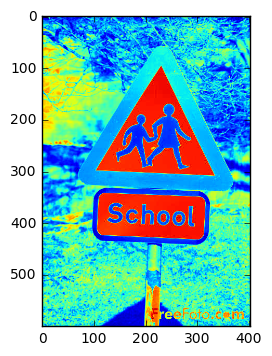

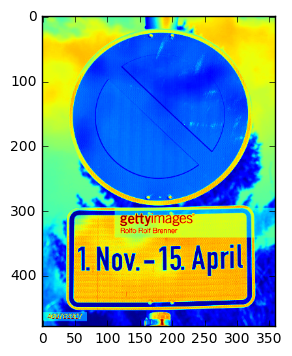

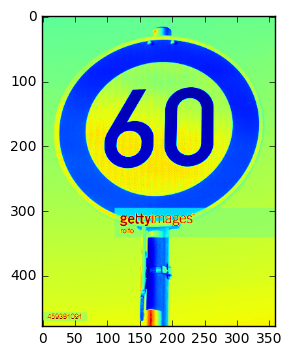

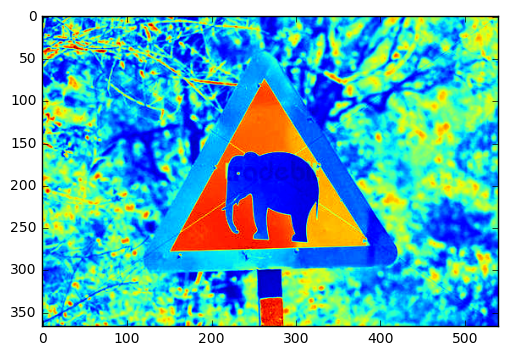

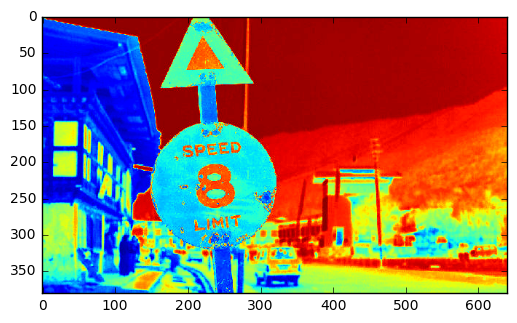

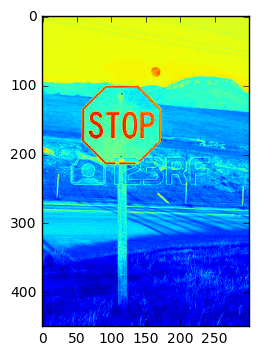

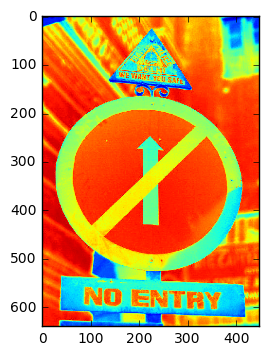

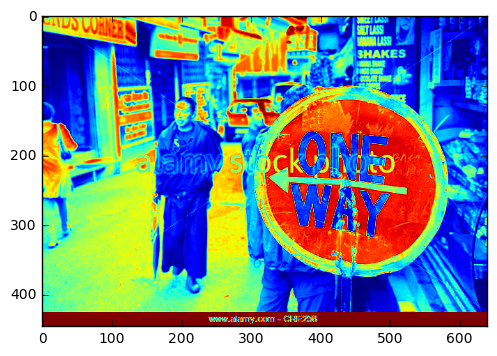

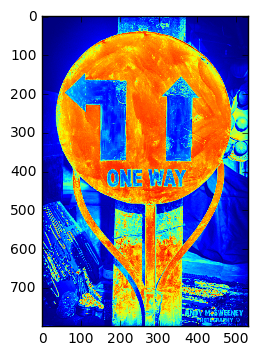

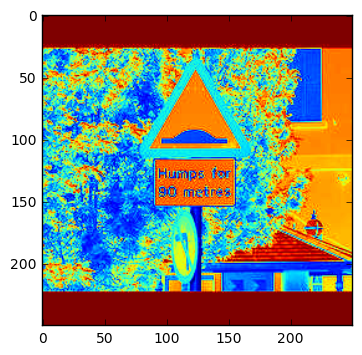

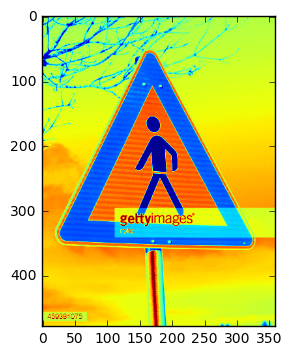

Test accuracy: 18.2%
True labels:
[28 31 13 14 17 35 33 22 27 17  3]
Predictions:
[21 40 13 11 12 35 12 38 28 22 18]


In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


def load_data(data_dir):
    count = 0
    images = np.zeros((len(os.listdir(data_dir)), 32, 32))
    for f in os.listdir(data_dir):
        im = cv2.imread(os.path.join(data_dir, f),0) #read image as gray scale
        plt_img = plt.imshow(im)
        plt.show()
        im = cv2.resize(im, (32, 32)) #resize to 32x32
        images[count] = im
        count += 1
    return images


    # Load training and testing datasets.
path_images= "Extra/"
images_pre = load_data(path_images)
labels_pre = np.array([28, 31, 13, 14, 17 , 35, 33, 22, 27 ,17,3 ]) #labelled the data by hand
images , labels = reformat(images_pre, labels_pre) #one hot encoding and adding num_channels
images = normalize_grayscale(images) #normalize images

with graph.as_default():

    tf_new_test_dataset = tf.constant(images)
    new_test_prediction = tf.nn.softmax(model(tf_new_test_dataset))
    predicted_labels = tf.argmax(new_test_prediction, 1)
    
print("Test accuracy: %.1f%%" % accuracy(new_test_prediction.eval(session=sess), labels))
predictions = sess.run([predicted_labels],feed_dict={tf_new_test_dataset:images})
print('True labels:')
print(labels_pre)
print('Predictions:')
print(predictions[0])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** In, India you find wired signs in the road https://upload.wikimedia.org/wikipedia/commons/1/13/Kannur_South_6%2C_Kerala%2C_India.jpg or https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/Nepal_road_sign_A7.svg/1024px-Nepal_road_sign_A7.svg.png there is a very likely chance that our training set and the test set would fail instead of Germany udacity should consider India. Maybe a human driving can understand http://cdn.scooppick.com/wp-content/uploads/2014/05/Indian-Road-Signs9.jpg or http://i.dailymail.co.uk/i/pix/2013/10/17/article-2464394-18CB153D00000578-862_634x447.jpg or http://i.dailymail.co.uk/i/pix/2013/10/17/article-2464394-18CB141C00000578-194_634x482.jpg . I took only general signs and a few ones which the classifier might not have seen it. Issues are that images from the internet are not of the same kind and size so it was an issue. The third image was meant to be a Yield actually. The Classifier can even predict Speed limit in some case.


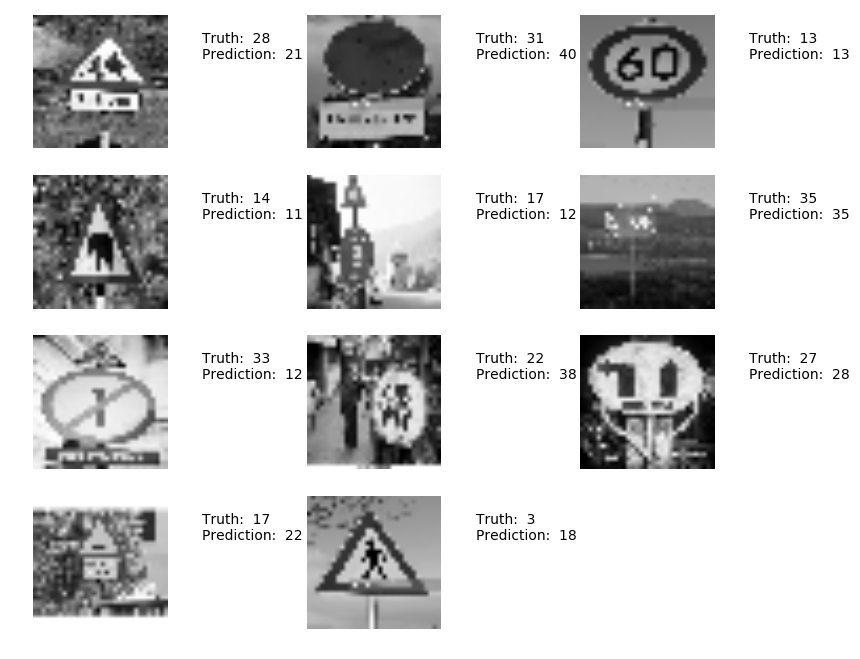

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
### Run the predictions here.
### Feel free to use as many code cells as needed.
fig = plt.figure(figsize=(10,10))
for i in range(len(images_pre)):
    plt.subplot(5,3,1+i)
    plt.axis('off')
    plt.text(40,10,"Truth:  {0}\nPrediction:  {1}".format(labels_pre[i], predictions[0][i]))
    plt.imshow(images_pre[i],cmap='gray')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**  It gave 25% accuracy. choosing a wired set I find 25% itself great. all those signs which I took aren't internationally recognized. and I took 8 images rather than 5. 

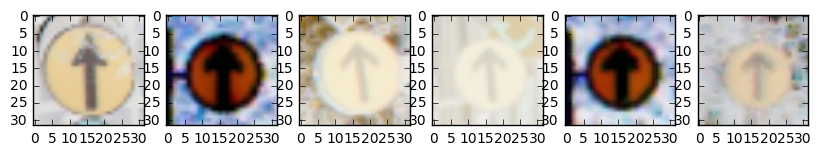

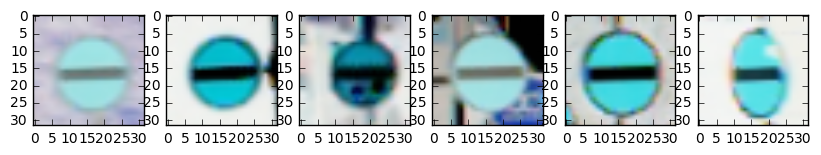

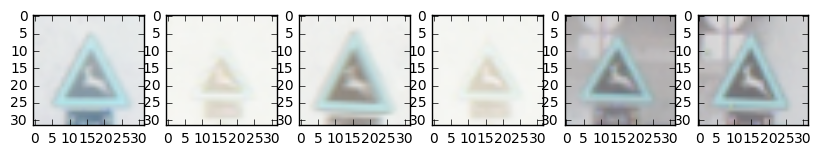

In [12]:
#Plotting a couple of stop signs from the test data set X_test and y_test

#plt.imshow(X_test[8]) #road work sign
#plt.imshow(X_test[11],X_test[13]) #100 sign
#plt.imshow(X_test[18])

def plot_signs(label, amount):
    count = 0
    signs = np.zeros((amount,32,32,3))
    for i in range(len(y_test)):
        if y_test[i] == label and count < amount:
            signs[count] = X_test[i]
            count +=1

    fig = plt.figure(figsize=(10,10))
    for i in range(len(signs)):
        plt.subplot(1,amount,1+i)
        plt.imshow(signs[i])

        
###PLOT SOME IMAGES FROM THE TEST SET TO COMPARE TO NEW DATA SET
plot_signs(35,6)
plot_signs(17,6) 
plot_signs(31,6) 

In [13]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
values,indices = tf.nn.top_k(new_test_prediction,k=5)
print(values.eval(session=sess))
print(indices.eval(session=sess))

[[  3.15507352e-01   1.86108336e-01   1.62865892e-01   1.36885494e-01
    7.43569508e-02]
 [  6.99611008e-01   2.14530081e-01   5.59027009e-02   1.60809662e-02
    7.50931725e-03]
 [  3.54897231e-01   3.35424364e-01   6.56625703e-02   6.08453080e-02
    5.69941141e-02]
 [  9.99711573e-01   1.93586515e-04   3.22186024e-05   2.87162220e-05
    2.83727386e-05]
 [  6.21426225e-01   3.37261260e-01   1.28035136e-02   8.86128657e-03
    8.58801510e-03]
 [  6.22455180e-01   2.39280164e-01   8.19880813e-02   1.51534677e-02
    1.29342703e-02]
 [  3.45708996e-01   2.02370793e-01   1.61515102e-01   1.18820079e-01
    5.02249338e-02]
 [  9.83908951e-01   1.38774039e-02   8.89881223e-04   5.50878234e-04
    2.97747581e-04]
 [  7.83191621e-01   1.43004477e-01   3.49992327e-02   3.34391445e-02
    1.74116367e-03]
 [  8.34466636e-01   1.10249169e-01   4.14615758e-02   5.07549662e-03
    4.84190462e-03]
 [  7.52910674e-01   1.75338924e-01   3.09121683e-02   1.80433262e-02
    5.41046914e-03]]
[[21 27 2

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The classifier needs more training data (including regional ones) to correctly identify these images. As does not correctly identify the images with predictions. Take my case with a deer and elephant both could be identified as Wild animals crossing. so more intense training should be given. For improving the prediction we can use samples with higher resolution images and build a CNN that can accept larger size images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.